In [5]:
import time as time
import copy
import numpy as np
from spydermesh import spydermesh
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
import csv
import sys
import os

plt.close("all")

In [2]:
casename = "2M"
spacer_grid_width = None
spacer_mat = None
if casename == '2Q':
    spacer_grid_width = 0.024512237496725212
    spacer_mat = 'spacer_material'

plot_pins = True
plot_lattice = True
cut_lattice = True
check_volumes = False

In [3]:
color_list  = [
    "red",
    "yellow",
    "green",
    "blue",
    "pink",
    "cyan",
    "magenta",
    "white",
    "orange",
    "purple",
]

#color_list = [
#    'red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black', 'white',
#    'gray', 'cyan', 'magenta', 'lime', 'maroon', 'navy', 'olive', 'teal', 'aqua', 'fuchsia',
#    'silver', 'gold', 'beige', 'ivory', 'khaki', 'lavender', 'peach', 'coral', 'turquoise', 'indigo'
#    ] 

# Convert the list to a set to remove duplicates
colors_set = set(color_list)

# Get a list of all named colors from matplotlib
all_named_colors = list(mcolors.CSS4_COLORS.keys())

# Add colors from all_named_colors to preferred_colors_set, avoiding duplicates
for color in all_named_colors:
    if color not in colors_set:
        colors_set.add(color)

# Convert the set back to a list
color_list = list(colors_set)

In [4]:
your_files = os.getcwd()

def read_csv_to_2d_array(file_path):
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        data = [row for row in reader]
    return np.asarray(data)

def count_frequencies(data):
    flattened_data = [item for row in data for item in row]  # Flatten 2D array into a 1D list
    cell_frequencies = Counter(flattened_data)
    print("cell name frequency:")
    total = 0
    for key, value in cell_frequencies.items():
        print(f'"{key}": {value}')
        total += value
    print("total: ",total)

    
csv_filename = 'FA_cell_names_1_family.csv'
csv_filepath = your_files+'/'+casename+'/'+csv_filename

lattice_csv = read_csv_to_2d_array(csv_filepath)

count_frequencies(lattice_csv)

if lattice_csv.shape[0] != lattice_csv.shape[1]:
    raise Exception('CSV array of cell names is not square.')
    
csv_size = lattice_csv.shape[0] #size of the assembly 

cell name frequency:
"c": 128
"fu": 136
"gt": 24
"it": 1
total:  289


In [5]:
pitch = 0.63  # used to create that are alter deployed by x&y symetries
full_pitch = pitch * 2

In [6]:
def create_fuel_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod,
    nsub_mod,
    mod_name,
    sectors,
    outer_mat,
    plot_pins
):

    pin = spydermesh(pitch, pin_name)


    # polygonalize circles
    for R, n, hs, mat in zip(radii, nsub, half_list, mat_list):
        pin.polygonalize_circle(R, n, mat, half_shift=hs, preserve_vol=True)

    # add an extra circle in moderator
    pin.polygonalize_circle(
            rad_mod, nsub_mod, mod_name, half_shift=False, preserve_vol=False, stretch=0.35)
    
    if spacer_grid_width:
        # add a thin rectangular outer skin in moderator
        pin.add_corner_verts(mod_name, p=pin.pitch-spacer_grid_width)
    else:
        # add a thin rectangular outer skin in moderator
        almost_pitch = np.max(pin.vert[-1][0])
        dp = pin.pitch - almost_pitch
        pin.add_corner_verts(mod_name, p=almost_pitch + dp / 2)
    # finish off moderator to fill the quarter pin pitch area
    pin.add_corner_verts(outer_mat)

    # sectorization
    for iring, sector in enumerate(sectors):
        pin.add_sector_intersection(sector, iring)
    pin.collect_all_vertices()
    pin.make_polygons()

    pin.deploy_qpc()

    if plot_pins:
        uniq_mat, mat_id, mat_count = np.unique(
            pin.mat_poly, return_index=False, return_inverse=True, return_counts=True
        )
        colors = []
        for id_ in mat_id:
            colors.append(color_list[id_])
        pin.plot_polygons(colors=colors)
    return pin


In [7]:
def create_gt_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod,
    nsub_mod,
    mod_name,
    sectors,
    outer_mat,
    plot_pins
):

    pin = spydermesh(pitch, pin_name)

    # polygonalize circles
    for R, n, hs, mat in zip(radii, nsub, half_list, mat_list):
        pin.polygonalize_circle(R, n, mat, half_shift=hs, preserve_vol=True)
    
    if spacer_grid_width:
        # add a thin rectangular outer skin in moderator
        pin.add_corner_verts(mod_name, p=pin.pitch-spacer_grid_width)
        if rad_mod >= pin.pitch-spacer_grid_width:
            sector_list = sectors[0:-1]
        else:
            # add an extra circle in moderator
            pin.polygonalize_circle(
                rad_mod, nsub_mod, mod_name, half_shift=True, preserve_vol=False, stretch=0.5)
            sector_list = sectors
    else:
        # add an extra circle in moderator
        pin.polygonalize_circle(
            rad_mod, nsub_mod, mod_name, half_shift=True, preserve_vol=False, stretch=0.5)
        # add a thin rectangular outer skin in moderator
        almost_pitch = np.max(pin.vert[-1][0])
        dp = pin.pitch - almost_pitch
        pin.add_corner_verts(mod_name, p=almost_pitch + dp / 2)
        sector_list = sectors
    # finish off moderator to fill the quarter pin pitch area
    pin.add_corner_verts(outer_mat)

    # sectorization
    for iring, sector in enumerate(sector_list):
        if iring == len(sectors) - 1:
            pin.add_sector_intersection(sector, iring, half_shift=False)
        else:
            pin.add_sector_intersection(sector, iring, half_shift=True)
    pin.collect_all_vertices()
    pin.make_polygons()

    pin.deploy_qpc()

    if plot_pins:
        uniq_mat, mat_id, mat_count = np.unique(
            pin.mat_poly, return_index=False, return_inverse=True, return_counts=True
        )
        colors = []
        for id_ in mat_id:
            colors.append(color_list[id_])
        pin.plot_polygons(colors=colors)
    return pin


In [8]:
class RectGrid:
    def __init__(self, pin_name, xlist, ylist, mat_name):
        self.name = pin_name
        self.xlist = xlist
        self.ylist = ylist
        self.vertices = self.create_vertices()
        self.polygons = self.create_cells()
        
        self.mat_poly = []
        for cell in self.polygons:
            self.mat_poly.append(mat_name)
        
        self.edge_vert_id = self.edge_id()

    def create_vertices(self):
        xx, yy = np.meshgrid(self.xlist, self.ylist)
        vertices = np.column_stack([xx.ravel(), yy.ravel()])
        return vertices

    def create_cells(self):
        num_x = len(self.xlist)
        num_y = len(self.ylist)
        cells = []

        for j in range(num_y - 1):
            for i in range(num_x - 1):
                # Calculate indices of the vertices of the current cell
                v0 = j * num_x + i
                v1 = v0 + 1
                v2 = v1 + num_x
                v3 = v0 + num_x
                cells.append([v0, v1, v2, v3, v0])

        return cells

    def edge_id(self):
        # IDs of the vertices that are on the periphery
        mask = np.zeros((len(self.vertices), 4), dtype=bool)
        extrema = np.zeros((2,2))
        for dim in range(2):
            extrema[0,dim] = np.min(self.vertices[:,dim])
            extrema[1,dim] = np.max(self.vertices[:,dim])
        counter = 0
        for dim in range(2):
            delta = np.abs(self.vertices[:, dim] - extrema[0,dim])
            mask_ = delta < 1e-9
            mask[:, counter] = mask_
            counter += 1
            delta = np.abs(self.vertices[:, dim] - extrema[1,dim])
            mask_ = delta < 1e-9
            mask[:, counter] = mask_
            counter += 1
        mask = np.logical_or.reduce(mask, axis=1)
        # get the indices where a vertex is along
        return np.where(mask)[0]  

In [9]:
# select a spyderweb pin using their name
def pick_pin(list_pins, name):
    for pin in list_pins:
        if pin.name == name:
            return copy.deepcopy(pin)
    raise ValueError("name {} not found in list of pins".format(name))


FUEL PIN


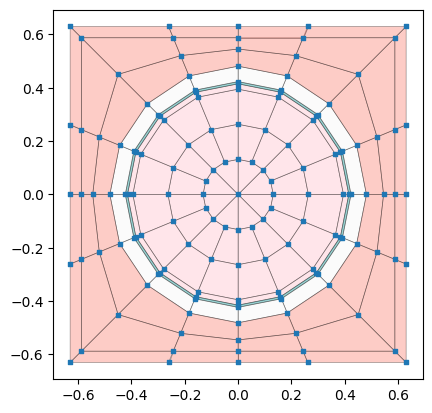

PYREX


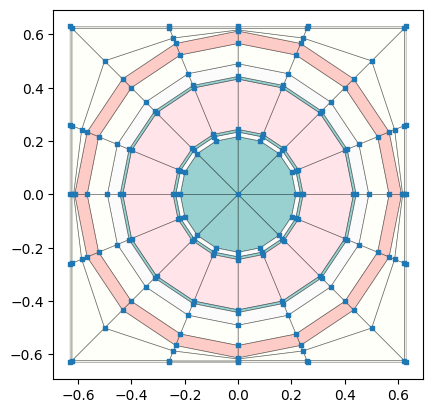

AIC


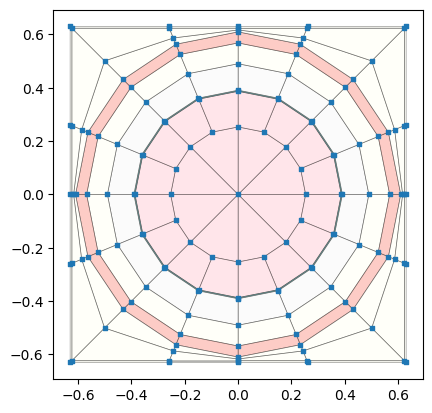

B4C


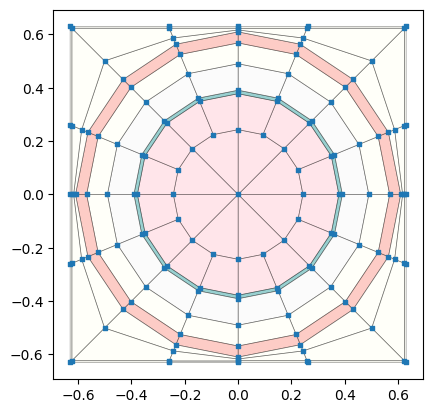

FUEL LOW


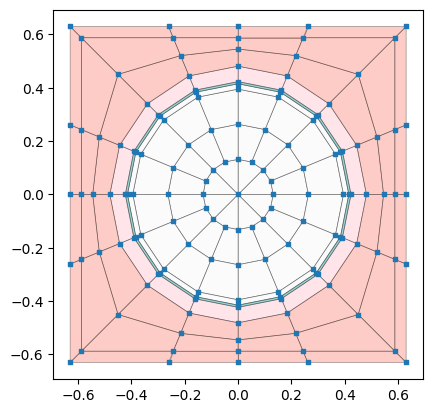

FUEL HIGH


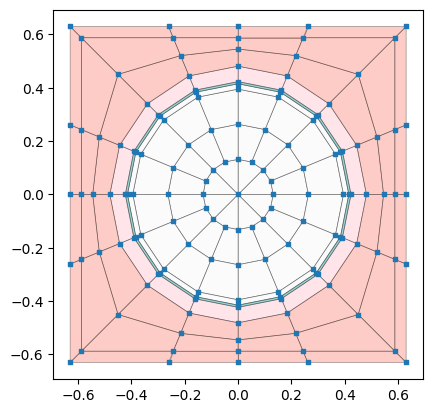

IFBA FUEL


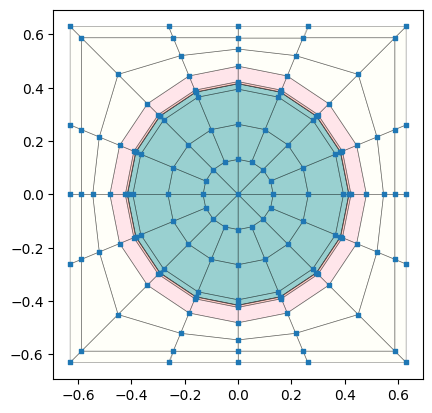

WABA


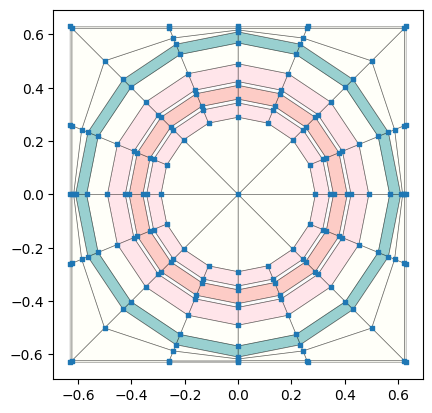

GADOLINIA


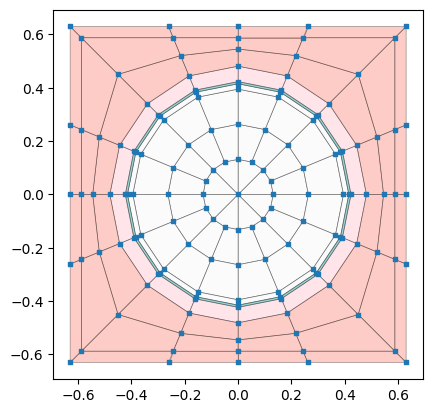

GUIDE TUBE


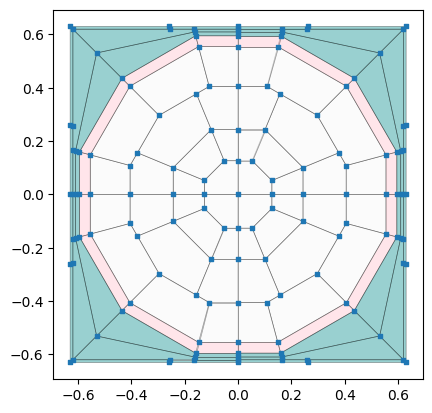

INSTRUMENT TUBE


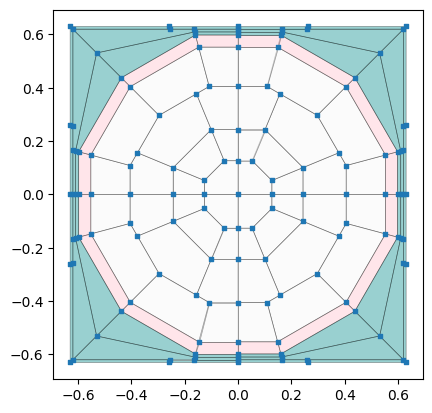

THIMBLE INSTRUMENT TUBE


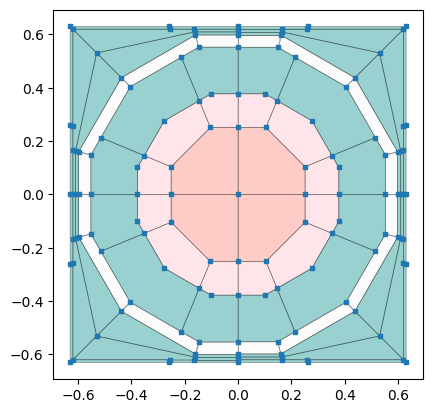

In [10]:
# gap size
half_water_gap = 0.04 # 0.63*2
# compute the angles in [0,pi/4]
n_angles = 3
ang = np.linspace(0, np.pi / 4, n_angles)
ang = np.append(ang,-ang)
ang = np.unique(ang)
ang = np.sort(ang)
# compute the positions
pos_x = np.tan(ang)*pitch
pos_y = np.array([ -half_water_gap / 2, 0, half_water_gap / 2 ])
pos_y = np.array([ -half_water_gap / 2, half_water_gap / 2 ])

mod_name='water_outside'
water_gap_H = RectGrid('H', pos_x, pos_y, mod_name)
water_gap_V = RectGrid('V', pos_y, pos_x, mod_name)
water_gap_C = RectGrid('C', pos_y, pos_y, mod_name)


# FUEL
print('FUEL PIN')
radii = [0.13, 0.26, 0.39, 0.4096, 0.418, 0.475]
nsub = [3, 3, 3, 3, 3, 3]
half_list = [False] * 6
rad_mod = 0.5
nsub_mod = 3
mod_name = "moderator"
outer_mat = spacer_mat if casename == '2Q' else mod_name
sectors = [1, 3, 3, 3, 3, 3, 3, 3,3]
pin_name = "fu"
# material names
mat_list = ["fuel", "fuel", "fuel", "fuel", "fuel gap", "fuel clad"]
uox = create_fuel_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod,
    nsub_mod,
    mod_name,
    sectors,
    outer_mat,
    plot_pins,
)


# PYREX
print('PYREX')
radii = [0.214, 0.231, 0.241, 0.427, 0.437, 0.484,0.559,0.605]
nsub = [3, 3, 3,3,3, 3, 3, 3]
half_list = [False] * 8
rad_mod = 0.61
nsub_mod = 3
mod_name = 'pyrex_water'
outer_mat = spacer_mat if casename == '2Q' else mod_name
sectors = [1, 3, 3, 3, 3, 3, 3, 3, 3,3,3]
pin_name = "p"
mat_list = ["pyrex_gap", "pyrex_clad", "pyrex_gap", "pyrex", "pyrex_gap", "pyrex_clad","pyrex_water","pyrex_guide"]
cell_P = create_fuel_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod,
    nsub_mod,
    mod_name,
    sectors,
    outer_mat,
    plot_pins,
)


# AIC
print('AIC')
radii = [0.25,0.382, 0.386, 0.484, 0.561, 0.602]
nsub = [3, 3, 3, 3, 3, 3]
half_list = [False] * 6
rad_mod = 0.61
nsub_mod = 3
mod_name = "AIC_water"
outer_mat = spacer_mat if casename == '2Q' else mod_name
sectors = [1, 3, 3, 3, 3, 3, 3, 3, 3]
pin_name = "a"
# material names
mat_list = ["AIC", "AIC", "AIC_gap", "AIC_clad", "AIC_water", "AIC_guide"]
cell_AIC = create_fuel_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod,
    nsub_mod,
    mod_name,
    sectors,
    outer_mat,
    plot_pins,
)


# B4C
print('B4C')
radii = [0.24,0.373, 0.386, 0.484, 0.561, 0.602]
nsub = [3, 3, 3, 3, 3, 3]
half_list = [False] * 6
rad_mod = 0.61
nsub_mod = 3
mod_name = "moderator_b4c_1_family"
outer_mat = spacer_mat if casename == '2Q' else mod_name
sectors = [1, 3, 3, 3, 3, 3, 3, 3, 3]
pin_name = "b"
# material names
mat_list = ["B4C_b4c_1_family", "B4C_b4c_1_family", "gap_b4c_1_family", "clad_b4c_1_family", "moderator_b4c_1_family", "guide_b4c_1_family"]
cell_B4C = create_fuel_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod,
    nsub_mod,
    mod_name,
    sectors,
    outer_mat,
    plot_pins,
)


# LOWER ENRICHED FUEL
print('FUEL LOW')
radii = [0.13, 0.26, 0.39, 0.4096, 0.418, 0.475]
nsub = [3, 3, 3, 3, 3, 3]
half_list = [False] * 6
rad_mod = 0.5
nsub_mod = 3
mod_name = "moderator_pincell_low_1_family"
outer_mat = spacer_mat if casename == '2Q' else mod_name
sectors = [1, 3, 3, 3, 3, 3, 3, 3, 3]
pin_name = "ful"
# material names
mat_list = ["fuel_pincell_low_1_family", "fuel_pincell_low_1_family", "fuel_pincell_low_1_family", "fuel_pincell_low_1_family", "gap_pincell_low_1_family", "clad_pincell_low_1_family"]
uox_low = create_fuel_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod,
    nsub_mod,
    mod_name,
    sectors,
    outer_mat,
    plot_pins,
)


# HIGHER ENRICHED FUEL
print('FUEL HIGH')
radii = [0.13, 0.26, 0.39, 0.4096, 0.418, 0.475]
nsub = [3, 3, 3, 3, 3, 3]
half_list = [False] * 6
rad_mod = 0.5
nsub_mod = 3
mod_name = "moderator_pincell_high_1_family"
outer_mat = spacer_mat if casename == '2Q' else mod_name
sectors = [1, 3, 3, 3, 3, 3, 3, 3, 3]
pin_name = "fuh"
# material names
mat_list = ["fuel_pincell_high_1_family", "fuel_pincell_high_1_family", "fuel_pincell_high_1_family", "fuel_pincell_high_1_family", "gap_pincell_high_1_family", "clad_pincell_high_1_family"]
uox_high = create_fuel_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod,
    nsub_mod,
    mod_name,
    sectors,
    outer_mat,
    plot_pins,
)


# COATED FUEL ELEMENT
print('IFBA FUEL')
radii = [0.13, 0.26, 0.39, 0.4096,0.4106, 0.418, 0.475]
nsub = [3, 3, 3, 3, 3, 3,3]
half_list = [False] * 7
rad_mod = 0.5
nsub_mod = 3
mod_name = "moderator_ifba"
outer_mat = spacer_mat if casename == '2Q' else mod_name
sectors = [1, 3, 3, 3, 3, 3, 3, 3, 3,3]
pin_name = "c"
# material names
mat_list = ["fuel_ifba", "fuel_ifba", "fuel_ifba", "fuel_ifba", "coat_ifba", "gap_ifba","clad_ifba"]
uox_ifba = create_fuel_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod,
    nsub_mod,
    mod_name,
    sectors,
    outer_mat,
    plot_pins,
)


# WABA
print('WABA')
radii = [0.286, 0.339, 0.353, 0.404,0.418, 0.484, 0.561,0.602]
nsub = [3, 3, 3, 3, 3, 3,3,3]
half_list = [False] * 8
rad_mod = 0.61
nsub_mod = 3
mod_name = "water_cell_waba"
outer_mat = spacer_mat if casename == '2Q' else mod_name
sectors = [1, 3, 3, 3, 3, 3, 3, 3,3, 3,3]
pin_name = "w"
# material names
mat_list = ["water_cell_waba", "clad_cell_waba", "gap_cell_waba", "poison_cell_waba", "gap_cell_waba", "clad_cell_waba","water_cell_waba","guide_cell_waba"]
uox_waba = create_fuel_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod,
    nsub_mod,
    mod_name,
    sectors,
    outer_mat,
    plot_pins,
)


# GADOLINIA
print('GADOLINIA')
radii = [0.13, 0.26, 0.39, 0.4096, 0.418, 0.475]
nsub = [3, 3, 3, 3, 3, 3]
half_list = [False] * 6
rad_mod = 0.5
nsub_mod = 3
mod_name = "moderator_gado"
outer_mat = spacer_mat if casename == '2Q' else mod_name
sectors = [1, 3, 3, 3, 3, 3, 3, 3, 3]
pin_name = "gd"
# material names
mat_list = ["fuel_gado", "fuel_gado", "fuel_gado", "fuel_gado", "gap_gado", "clad_gado"]
uox_gado = create_fuel_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod,
    nsub_mod,
    mod_name,
    sectors,
    outer_mat,
    plot_pins,
)


# GUIDETUBE
print('GUIDE TUBE')
radii = [0.13, 0.25, 0.41, 0.561, 0.602]
nsub = [1, 1, 2, 2, 2]
half_list = [True] * 5
rad_mod_gt = 0.610
nsub_mod_gt = 2
mod_name_gt = 'gt-water-out'
outer_mat = spacer_mat if casename == '2Q' else mod_name_gt
sectors = [0, 1, 1, 2, 2, 2, 2, 3]
pin_name = "gt"
mat_list = ["gt-water-in", "gt-water-in", "gt-water-in", "gt-water-in", "gt-clad"]
gtube = create_gt_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod_gt,
    nsub_mod_gt,
    mod_name_gt,
    sectors,
    outer_mat,
    plot_pins,
)


# INSTRUMENT TUBE
print('INSTRUMENT TUBE')
radii = [0.13, 0.25, 0.41, 0.559, 0.605]
#nsub = [1, 1, 3, 3, 3]
nsub = [1, 1, 2, 2, 2]
half_list = [True] * 5
rad_mod_it = 0.610
nsub_mod_it = 2
mod_name_it = "it-water-out"
outer_mat = spacer_mat if casename == '2Q' else mod_name_it
#sectors = [0, 1, 1, 3, 3, 3, 3, 3]
sectors = [0, 1, 1, 2, 2, 2, 2, 3]
pin_name = "it"
mat_list = ["it-water-in", "it-water-in", "it-water-in", "it-water-in", "it-clad"]
ginstru = create_gt_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod_it,
    nsub_mod_it,
    mod_name_it,
    sectors,
    outer_mat,
    plot_pins,
)


# THIMBLE INSTRUMENT TUBE
print('THIMBLE INSTRUMENT TUBE')
radii = [0.258, 0.382, 0.559, 0.605]
nsub = [1,  2, 2, 2]
half_list = [True] * 4
rad_mod_it = 0.610
nsub_mod_it = 2
mod_name_it = "it-water"
outer_mat = spacer_mat if casename == '2Q' else mod_name_it
sectors = [0, 1, 1, 2, 2, 2, 3]
pin_name = "itt"
mat_list = ["it_gap", "instrument", "it-water", "it-clad"]
ginstru_I = create_gt_pin(
    pin_name,
    radii,
    nsub,
    half_list,
    mat_list,
    rad_mod_it,
    nsub_mod_it,
    mod_name_it,
    sectors,
    outer_mat,
    plot_pins,
)

In [11]:
# %% lattice: empty spyderweb structure with the **full** pin pitch
lattice = spydermesh(full_pitch, "lat")

# list all of the possible pin types that were created
list_pins = [uox, cell_P, cell_AIC, cell_B4C, uox_low, uox_high, 
             uox_ifba, uox_waba, uox_gado, gtube, ginstru, ginstru_I,
             water_gap_H,water_gap_V,water_gap_C,]

lat = np.empty((19, 19), dtype="<U3")

In [12]:
lat[1:-1,1:-1] = lattice_csv

lat[:, 0] = "V"
lat[:, -1] = "V"
lat[0, :] = "H"
lat[-1, :] = "H"
lat[0, 0] = "C"
lat[0, -1] = "C"
lat[-1, 0] = "C"
lat[-1, -1] = "C"
print("casename=",casename,"\n",lat)

if not lat.any():
    print('Missing indices in lat variable.')

casename= 2M 
 [['C' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
  'C']
 ['V' 'c' 'fu' 'fu' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'c' 'fu' 'fu' 'c' 'fu'
  'fu' 'fu' 'c' 'V']
 ['V' 'fu' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'fu'
  'c' 'fu' 'fu' 'V']
 ['V' 'fu' 'c' 'fu' 'c' 'c' 'gt' 'c' 'c' 'gt' 'c' 'c' 'gt' 'c' 'c' 'fu'
  'c' 'fu' 'V']
 ['V' 'fu' 'fu' 'c' 'gt' 'c' 'c' 'fu' 'fu' 'c' 'fu' 'fu' 'c' 'c' 'gt' 'c'
  'fu' 'fu' 'V']
 ['V' 'c' 'fu' 'c' 'c' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'c' 'c'
  'fu' 'c' 'V']
 ['V' 'fu' 'c' 'gt' 'c' 'c' 'gt' 'c' 'c' 'gt' 'c' 'c' 'gt' 'c' 'c' 'gt'
  'c' 'fu' 'V']
 ['V' 'fu' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'fu'
  'c' 'fu' 'fu' 'V']
 ['V' 'c' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'fu'
  'c' 'fu' 'c' 'V']
 ['V' 'fu' 'c' 'gt' 'c' 'c' 'gt' 'c' 'c' 'it' 'c' 'c' 'gt' 'c' 'c' 'gt'
  'c' 'fu' 'V']
 ['V' 'c' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'fu' 'c' 'fu' 'fu'
  'c' 'fu' 'c' 'V']


In [13]:
nx, ny = lat.shape
nx = 10
ny = 10
dx_prev, dy_prev = 0., 0.

for i in range(nx):
    if i == 0:
        first_row = True
        delta_y = 0.
    else:
        first_row = False
        
    for j in range(ny):
        
        pin = pick_pin(list_pins, lat[i, j])
        # print(fuel.polygons[-1])
        # print(pin.polygons[-1])
        pt_min = np.min(pin.vertices, axis=0)
        pt_max = np.max(pin.vertices, axis=0)
        dx, dy = pt_max - pt_min

        if j == 0:
            first_col = True
            delta_x = 0.
        else:
            first_col = False

        if first_row and first_col:
            lattice.nverts = len(pin.vertices)
            lattice.vertices = np.copy(pin.vertices)
            lattice.polygons = pin.polygons.copy()
            lattice.mat_poly = pin.mat_poly.copy()
            lattice.edge_vert_id = pin.edge_vert_id.copy()
            
        else:
            # update vertex id's
            poly_pin = pin.polygons.copy()
            for ip, p in enumerate(poly_pin):
                for iv, vid in enumerate(p):
                    pin.polygons[ip][iv] += lattice.nverts
            # update list of polygons
            lattice.polygons += pin.polygons
            # shift vertex locations
            new_verts = np.copy(pin.vertices)
            # print("delta_x=", dx_prev_2 + dx_cur_2,", delta_y=", dy_prev_2 + dy_cur_2,"\n")
            # update skip in x starting at second column
            if j > 0 : 
                delta_x += dx_prev/2 + dx/2
            # update skip in y starting at second row
            if j == 0 and i > 0 : 
                delta_y += dy_prev/2 + dy/2
                
            new_verts[:, 0] += delta_x 
            new_verts[:, 1] -= delta_y 
            # update vertex coordinate array
            lattice.vertices = np.vstack((lattice.vertices, new_verts))
            # update polygon names
            lattice.mat_poly += pin.mat_poly
            # update indices of vertices that live on the periphery of a pin cell
            edge_vert_id = pin.edge_vert_id[:] + lattice.nverts
            lattice.edge_vert_id = np.hstack((lattice.edge_vert_id, edge_vert_id))
            # update # of vertices so far
            lattice.nverts += len(pin.vertices)
        
        # save previous cell sizes
        dx_prev, dy_prev = dx, dy


print(lattice.vertices.shape)

(12449, 2)


In [14]:
t0 = time.time()
lattice.make_vertices_unique2()
print('elapsed time = {:.2f} s'.format(time.time()-t0))

print(lattice.vertices.shape)

loop over unique vertices
loop over potentially duplicated vertices
elapsed time = 1.46 s
(11684, 2)


In [15]:
# delete portions of the assembly

x_lim = pitch*8.15
y_lim = pitch*8.15

if cut_lattice == True:
    # if all of a polygon's vertexes are within the given range, it may stay
    poly = lattice.polygons.copy()
    matpoly = lattice.mat_poly.copy()
    lattice.polygons = []
    lattice.mat_poly = []
    for ip, polygon in enumerate(poly):
        if all(xcord <= x_lim for xcord in lattice.vertices[polygon][:,0]) and all(ycord >= -y_lim for ycord in lattice.vertices[polygon][:,1]): #and lattice.vertices[polygon][:,1].all() >= -pitch*1:
            lattice.polygons.append(polygon) 
            lattice.mat_poly.append(matpoly[ip])
    print('Polygons: ',len(lattice.polygons))
    
    # if a vertex is referenced by a polygon, it may stay
    unique_inds = []
    for i in range(0,len(lattice.polygons)):
        unique_inds.extend(np.unique(lattice.polygons[i]))
    verts = lattice.vertices.copy()
    #lattice.vertices = np.array([0,0])
    for ip, ver in enumerate(verts):
        if ip not in unique_inds:
            #lattice.vertices = np.vstack((lattice.vertices, verts[ip,:]))
            lattice.vertices[ip] = 0
    #lattice.vertices = lattice.vertices[1:-1,:]
    lattice.nverts = len(lattice.vertices)
    print('Vertices',lattice.vertices.shape)
    
    #verts = lattice.vertices
    #lattice.vertices = np.array([0,0])
    #for v, vert in enumerate(verts):
    #    if verts[v,0] <= pitch*2:
    #        lattice.vertices = np.vstack((lattice.vertices, verts[v,:]))
    #lattice.vertices = lattice.vertices[1:-1,:]
    #lattice.nverts = len(lattice.vertices)
    #len(lattice.vertices)
    
    edge_ids = lattice.edge_vert_id.copy()
    vert_length = lattice.vertices.shape[0]
    lattice.edge_vert_id = np.array([],dtype=np.int32)
    for ij, ids in enumerate(edge_ids):
        if ids < vert_length:
            lattice.edge_vert_id = np.append(lattice.edge_vert_id,int(ids))
    print('Edge verts: ',len(lattice.edge_vert_id))
    
    t0 = time.time()
    lattice.make_vertices_unique2()
    print('elapsed time = {:.2f} s'.format(time.time()-t0))
    
    print(lattice.vertices.shape)

Polygons:  10232
Vertices (11684, 2)
Edge verts:  1397
loop over unique vertices
loop over potentially duplicated vertices
elapsed time = 1.50 s
(11564, 2)


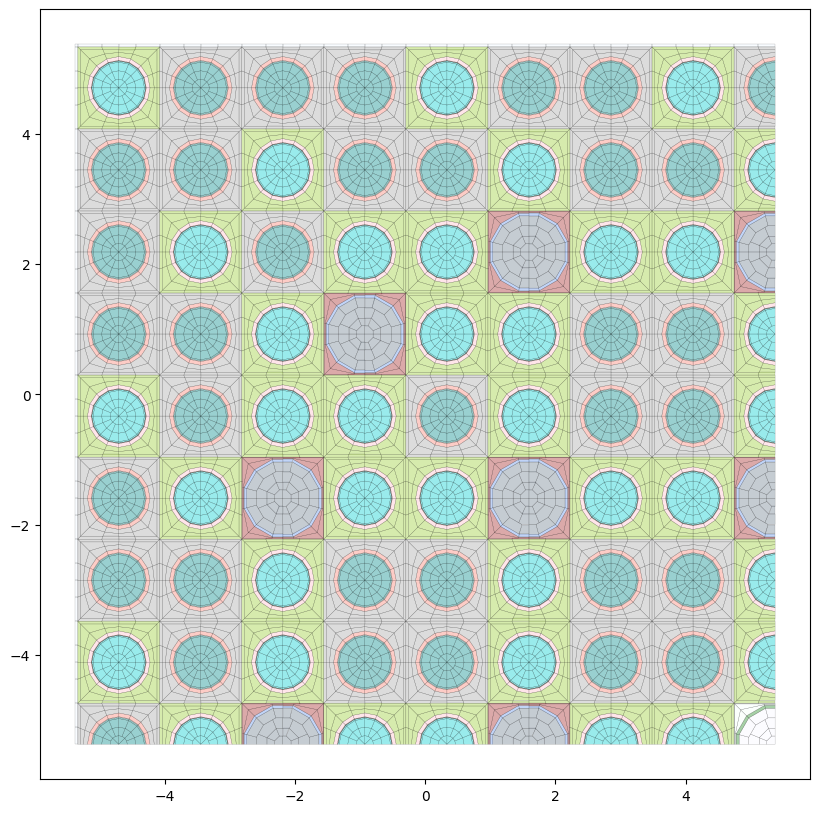

In [16]:
if plot_lattice==True:
    uniq_mat, mat_id, mat_count = np.unique(
        lattice.mat_poly, return_index=False, return_inverse=True, return_counts=True)
    colors = []
    for id_ in mat_id:
        colors.append(color_list[id_])
    lattice.plot_polygons(colors=colors, size_=0.1, lw_=0.2, plot_size=[10,10])

In [17]:
lattice.export_to_obj("lattice_{}.obj".format(casename))

# %% verif area
pt_min = np.min(lattice.vertices, axis=0)
pt_max = np.max(lattice.vertices, axis=0)
dx, dy = pt_max - pt_min
A_truth = dx*dy

A_sum = 0.0
for i, poly in enumerate(lattice.polygons):
    # print(i,poly)
    coord = lattice.vertices[poly]
    A = lattice.PolyArea_noabs(coord[:, 0], coord[:, 1])
    if A < 0:
        print("A<0", poly, coord, A)
    A_sum += A
print("Asum error=", A_sum - A_truth)  
print(len(mat_id))

Asum error= -3.836930773104541e-13
10232


# CHECK FOR NEGATIVE VOLUMES!!!!

In [18]:
if check_volumes == True:
    from pyopensn.mesh import FromFileMeshGenerator
    meshgen = FromFileMeshGenerator(
        filename="lattice_"+casename+".obj")
    grid = meshgen.Execute()

In [19]:
#uox.export_to_obj("lattice_{}.obj".format(casename))